In [ ]:
%pip install kaggle pandas numpy scikit-learn xgboost matplotlib seaborn plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configure Kaggle API (Upload your kaggle.json file to Colab)
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d patelris/crop-yield-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset
License(s): world-bank
crop-yield-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
!unzip crop-yield-prediction-dataset.zip

Archive:  crop-yield-prediction-dataset.zip
  inflating: pesticides.csv          
  inflating: rainfall.csv            
  inflating: temp.csv                
  inflating: yield.csv               
  inflating: yield_df.csv            


In [13]:
# Load the dataset
df = pd.read_csv('yield_df.csv')

In [15]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (28242, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [17]:
print("\nFirst few rows:")
df.head()


First few rows:


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [18]:
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,14120.500000,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,28241.000000,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [19]:
# Data Exploration and Visualization
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


In [21]:
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
Area: 101 unique values
Item: 10 unique values


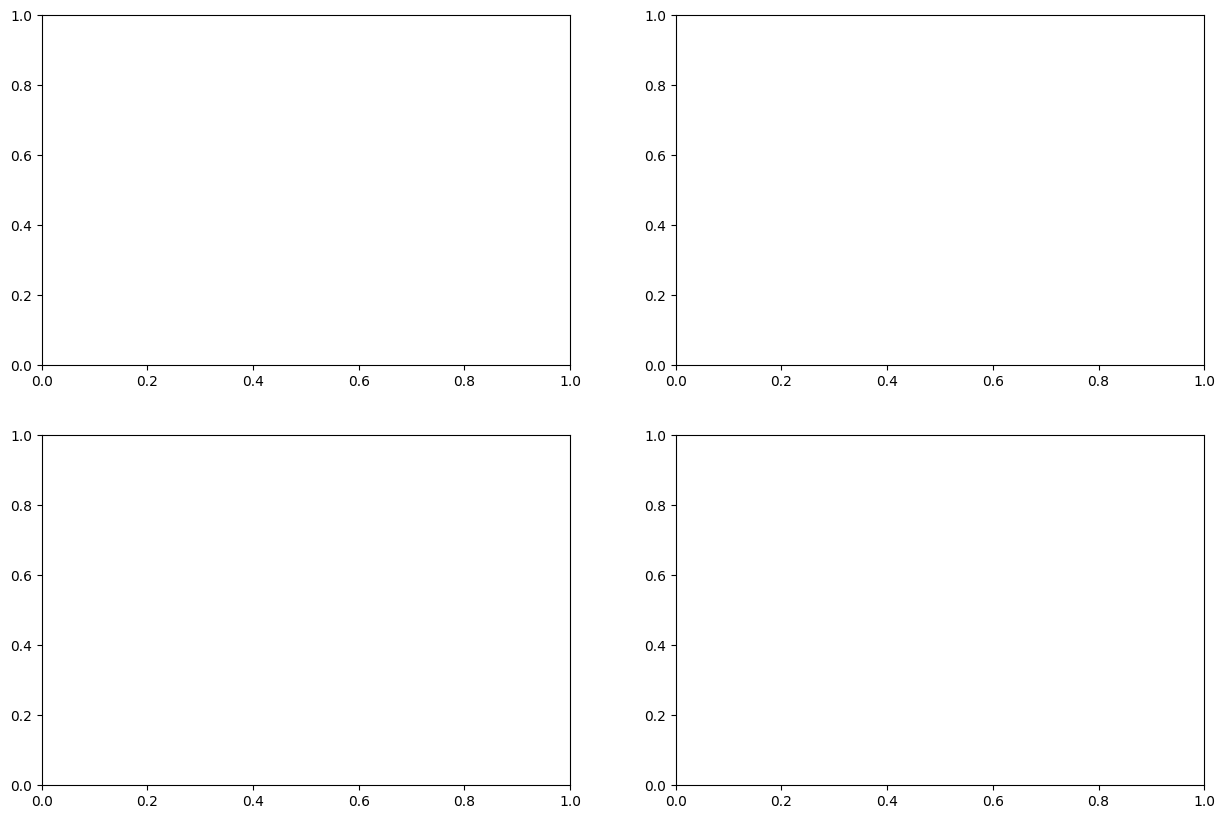

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

In [24]:
# Yield distribution
axes[0,0].hist(df['hg/ha_yield'], bins=50, alpha=0.7)
axes[0,0].set_title('Distribution of Crop Yield')
axes[0,0].set_xlabel('Yield (hg/ha)')

Text(0.5, 424.44444444444446, 'Yield (hg/ha)')

In [25]:
# Top crops by average yield
crop_yield = df.groupby('Item')['hg/ha_yield'].mean().sort_values(ascending=False).head(10)
axes[0,1].barh(range(len(crop_yield)), crop_yield.values)
axes[0,1].set_yticks(range(len(crop_yield)))
axes[0,1].set_yticklabels(crop_yield.index)
axes[0,1].set_title('Top 10 Crops by Average Yield')

Text(0.5, 1.0, 'Top 10 Crops by Average Yield')

In [26]:
# Yield by year trend
yearly_yield = df.groupby('Year')['hg/ha_yield'].mean()
axes[1,0].plot(yearly_yield.index, yearly_yield.values)
axes[1,0].set_title('Average Yield Trend Over Years')
axes[1,0].set_xlabel('Year')


Text(0.5, 4.4444444444444375, 'Year')

In [27]:
axes[1,1].scatter(df['average_rain_fall_mm_per_year'], df['hg/ha_yield'], alpha=0.5)
axes[1,1].set_title('Rainfall vs Yield')
axes[1,1].set_xlabel('Rainfall (mm/year)')
axes[1,1].set_ylabel('Yield (hg/ha)')

Text(638.5353535353535, 0.5, 'Yield (hg/ha)')

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [30]:
# Focus on South Asian countries
south_asian_countries = ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan', 'Afghanistan']
df_south_asia = df[df['Area'].isin(south_asian_countries)].copy()

In [31]:
print(f"\nSouth Asian data shape: {df_south_asia.shape}")
print("Countries in South Asian subset:")
print(df_south_asia['Area'].value_counts())


South Asian data shape: (6090, 8)
Countries in South Asian subset:
Area
India         4048
Pakistan      1449
Bangladesh     294
Sri Lanka      184
Nepal          115
Name: count, dtype: int64


In [33]:
# Feature Engineering
def create_features(df):
    df_processed = df.copy()

    # Create interaction features
    df_processed['temp_rainfall_ratio'] = df_processed['avg_temp'] / (df_processed['average_rain_fall_mm_per_year'] + 1)

    # Since Area_harvested doesn't exist, we'll create pesticide intensity based on year (as proxy for farming intensity)
    df_processed['pesticide_intensity'] = df_processed['pesticides_tonnes'] / (df_processed['Year'] - 1960 + 1)

    # Climate categorization
    df_processed['climate_zone'] = pd.cut(df_processed['avg_temp'],
                                        bins=[0, 15, 25, 35, 50],
                                        labels=['Cold', 'Temperate', 'Warm', 'Hot'])

    # Rainfall categorization
    df_processed['rainfall_zone'] = pd.cut(df_processed['average_rain_fall_mm_per_year'],
                                         bins=[0, 500, 1000, 1500, 5000],
                                         labels=['Low', 'Medium', 'High', 'Very High'])

    return df_processed

In [34]:
# Apply feature engineering
df_processed = create_features(df)
df_sa_processed = create_features(df_south_asia)

In [35]:
# Prepare data for modeling
def prepare_data(df):
    # Select features
    feature_cols = ['Year', 'avg_temp', 'average_rain_fall_mm_per_year',
                   'pesticides_tonnes', 'temp_rainfall_ratio', 'pesticide_intensity']

    # Encode categorical variables
    le_area = LabelEncoder()
    le_item = LabelEncoder()
    le_climate = LabelEncoder()
    le_rainfall = LabelEncoder()

    df_model = df.copy()
    df_model['Area_encoded'] = le_area.fit_transform(df_model['Area'])
    df_model['Item_encoded'] = le_item.fit_transform(df_model['Item'])
    df_model['climate_zone_encoded'] = le_climate.fit_transform(df_model['climate_zone'])
    df_model['rainfall_zone_encoded'] = le_rainfall.fit_transform(df_model['rainfall_zone'])

    feature_cols.extend(['Area_encoded', 'Item_encoded', 'climate_zone_encoded', 'rainfall_zone_encoded'])

    X = df_model[feature_cols]
    y = df_model['hg/ha_yield']

    return X, y, (le_area, le_item, le_climate, le_rainfall)

In [36]:
# Prepare global and South Asian datasets
X_global, y_global, encoders_global = prepare_data(df_processed)
X_sa, y_sa, encoders_sa = prepare_data(df_sa_processed)

In [37]:
print("Global dataset features shape:", X_global.shape)
print("South Asian dataset features shape:", X_sa.shape)

Global dataset features shape: (28242, 10)
South Asian dataset features shape: (6090, 10)


In [38]:
# Split the data
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_global, y_global, test_size=0.2, random_state=42)

In [39]:
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(
    X_sa, y_sa, test_size=0.2, random_state=42)

In [40]:
# Scale features
scaler_global = StandardScaler()
scaler_sa = StandardScaler()

In [41]:
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled = scaler_global.transform(X_test_global)

In [42]:
X_train_sa_scaled = scaler_sa.fit_transform(X_train_sa)
X_test_sa_scaled = scaler_sa.transform(X_test_sa)

In [43]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, model_name=""):
    results = {}

    print(f"\n{'='*20} {model_name} {'='*20}")

    # Random Forest
    print("Training Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)

    results['Random Forest'] = {'RMSE': rf_rmse, 'MAE': rf_mae, 'R2': rf_r2, 'model': rf}

    # XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    results['XGBoost'] = {'RMSE': xgb_rmse, 'MAE': xgb_mae, 'R2': xgb_r2, 'model': xgb_model}

    # Print results
    for model_name, metrics in results.items():
        print(f"\n{model_name} Results:")
        print(f"  RMSE: {metrics['RMSE']:.2f}")
        print(f"  MAE: {metrics['MAE']:.2f}")
        print(f"  R²: {metrics['R2']:.4f}")

    return results


In [44]:
# Train models on both datasets
print("Training models on Global dataset...")
global_results = train_and_evaluate_models(X_train_global_scaled, X_test_global_scaled,
                                         y_train_global, y_test_global, "Global Dataset")

Training models on Global dataset...

==================== Global Dataset ====================
Training Random Forest...
Training XGBoost...

Random Forest Results:
  RMSE: 10482.73
  MAE: 3843.09
  R²: 0.9849

XGBoost Results:
  RMSE: 14108.48
  MAE: 7958.27
  R²: 0.9726


In [45]:
print("\nTraining models on South Asian dataset...")
sa_results = train_and_evaluate_models(X_train_sa_scaled, X_test_sa_scaled,
                                     y_train_sa, y_test_sa, "South Asian Dataset")


Training models on South Asian dataset...

==================== South Asian Dataset ====================
Training Random Forest...
Training XGBoost...

Random Forest Results:
  RMSE: 1199.08
  MAE: 259.07
  R²: 0.9998

XGBoost Results:
  RMSE: 1308.74
  MAE: 504.33
  R²: 0.9998


In [46]:
# Hyperparameter tuning for best models
def hyperparameter_tuning(X_train, y_train, model_type='xgboost'):
    if model_type == 'xgboost':
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
        model = xgb.XGBRegressor(random_state=42)
    else:
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestRegressor(random_state=42)

    random_search = RandomizedSearchCV(
        model, param_dist, n_iter=20, cv=5,
        scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

In [47]:
# Tune XGBoost for South Asian data (best performing region-specific model)
print("\nHyperparameter tuning for South Asian XGBoost model...")
best_sa_model, best_params = hyperparameter_tuning(X_train_sa_scaled, y_train_sa, 'xgboost')


Hyperparameter tuning for South Asian XGBoost model...


In [48]:
print("Best parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Best parameters:
  subsample: 1.0
  n_estimators: 300
  max_depth: 9
  learning_rate: 0.1
  colsample_bytree: 0.9


In [49]:
# Final evaluation with tuned model
final_pred = best_sa_model.predict(X_test_sa_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test_sa, final_pred))
final_mae = mean_absolute_error(y_test_sa, final_pred)
final_r2 = r2_score(y_test_sa, final_pred)

In [50]:
print(f"\nFinal Tuned Model Performance (South Asian Dataset):")
print(f"  RMSE: {final_rmse:.2f}")
print(f"  MAE: {final_mae:.2f}")
print(f"  R²: {final_r2:.4f}")


Final Tuned Model Performance (South Asian Dataset):
  RMSE: 790.60
  MAE: 293.01
  R²: 0.9999


In [51]:
# Feature importance
feature_names = ['Year', 'Avg Temp', 'Rainfall', 'Pesticides', 'Temp/Rainfall Ratio',
                'Pesticide Intensity', 'Area', 'Crop', 'Climate Zone', 'Rainfall Zone']

In [52]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_sa_model.feature_importances_
}).sort_values('importance', ascending=False)

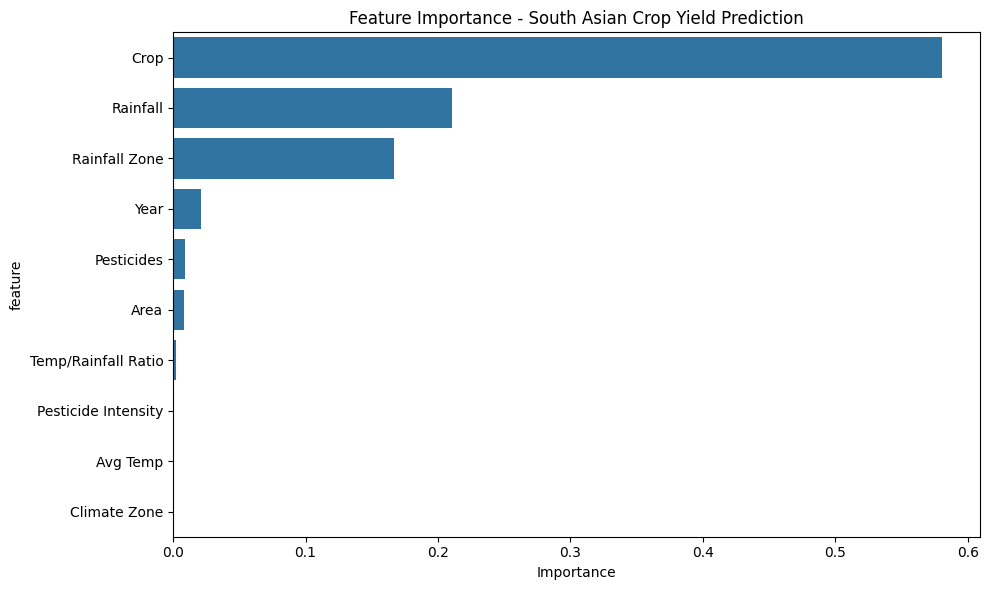

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance - South Asian Crop Yield Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [54]:
print("\nTop 5 Most Important Features:")
print(importance_df.head())


Top 5 Most Important Features:
         feature  importance
7           Crop    0.580200
2       Rainfall    0.210690
9  Rainfall Zone    0.166926
0           Year    0.021327
3     Pesticides    0.008803


In [55]:
model_artifacts = {
    'model': best_sa_model,
    'scaler': scaler_sa,
    'encoders': encoders_sa,
    'feature_names': feature_names,
    'south_asian_countries': south_asian_countries
}

In [56]:
# Save to pickle file
with open('crop_yield_model_sa.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)